# Analyzing Sentiment Trends with Twitter Data

## Introduction

This notebook will focus on analyzing the text data pulled with Twint. It contains the following:

* Sentiment tagging with Textblob
* Text cleaning, processing, and examination
* Topic modeling based on sentiment

Due to the nature of Twitter/Twint, lots of cleaning is needed to remove things like URLs and symbols to get the most meaning from the data. Some data cleaning is done before sentiment matching, i.e. removing URLs/twitter handles so that they don't affect the polarity score. However most is done after sentiment tagging to tokenize the data for clustering.

In [1]:
import pandas as pd
from textblob import TextBlob
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt

#NLP
import re
import nltk
import string
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

#pulling in py file that maps contractions to full words
import sys
sys.path.insert(1, './Files')
from contractions import CONTRACTION_MAP

#topic modeling
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from pprint import pprint

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('data/twint_scraped_clean.csv',  usecols=['date', 'tweet', 'geo'])

In [3]:
#remove data from 12.31 that pulled in
df = df[df['date'] >= '2021-01-01'] 

I've read in the data pulled with Twint. Now I'm going to use regex to remove a lot of the stuff in the tweets that I don't want to factor into my analysis, such as links, symbols, and @handles. 

## Cleaning Text with Regex

The Regex package will help me get non-informative text out of my data by writing patterns to recognize URLs and handles, and using substitution to remove them. I want to do this before assigning a sentiment score in case it throws anything off.

In [4]:
#creating a new clean column to remove URLs and @ mentions
df['clean_text'] = df['tweet']

#first, replacing some of the weird characters that twint is pulling in
df['clean_text'] = df['clean_text'].str.replace("â€", "'")
df['clean_text'] = df['clean_text'].str.replace("™", "'")

#removing links
df['clean_text'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]
df['clean_text'] = [re.sub(r'(https://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['clean_text']]

#removing handles
df['clean_text'] = [re.sub(r'@[^\s]+', '', tweet) for tweet in df['clean_text']]

#removing hashtag symbols but keeping the words
df['clean_text'] = [re.sub(r"#", "", tweet) for tweet in df['clean_text']]


Much better, I can now focus on the content of the text.

In [5]:
df.head()

,date,tweet,geo,clean_text
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can''t be stopped."
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things"
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn''t pretend adverse effects don''t exist."


## Assinging a Sentiment with Textblob

I'm using the Textblob library which can run a polarity score to analyze the text content to determine how negative or positive it is on a scale of -1 (most negative) to 1 (most positive). While this capability isn't perfect, it can do a great job of assigning sentiment across large datasets quickly.

After creating a function to score the text, I am adding a column to display the score and another column to classify that score based on Textblob's guidelines.

In [6]:
def get_polarity(text):
    
    """ 
    assign tweet a polarity score between -1, 1
    """
    
    return TextBlob(text).sentiment.polarity

In [7]:
# new column to display scores
df['tb_polarity'] = df['clean_text'].apply(get_polarity)

In [8]:
# new column to label sentiment based on score
df['tb_sentiment'] = ''
df.loc[df.tb_polarity > 0, 'tb_sentiment'] = 'positive'
df.loc[df.tb_polarity == 0, 'tb_sentiment'] = 'neutral'
df.loc[df.tb_polarity < 0, 'tb_sentiment'] = 'negative'

While this method is effective, I can see from a preview that it does have a hard time recognizing negativity, which will be an important caveat for analysis. 

In [9]:
df.head()

,date,tweet,geo,clean_text,tb_polarity,tb_sentiment
0,2021-06-13,"@CFetzRun @DioAlexandro2 @deathforeskin @ALV550 @jonmchu It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus canâ€™t be stopped.",chicago,"It was definitely required in every public location (library, DMV, etc). Also in most private locations (grocery stores, etc). Other countries are suffering too, lol. Not just US. Japan is still in a state of emergency. Canada has barely any vaccines. The virus can''t be stopped.",0.175000,positive
1,2021-06-13,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",chicago,"Went to the park where a guitar-bass-drum jazz trio plays every Sunday and I GOT TO SEE MORE FRIENDS, INCLUDING SOME TWO DAYS IN A ROW. A vaccine and a summer are some pretty wonderful things",0.583333,positive
2,2021-06-13,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian https://t.co/dcocHClLVd,chicago,Covid cases fall across US but experts warn of dangers of vaccine hesitancy - The Guardian,0.000000,neutral
3,2021-06-13,Sogard avoided that tag at second like it was the COVID vaccine,chicago,Sogard avoided that tag at second like it was the COVID vaccine,0.000000,neutral
4,2021-06-13,"@TheEliKlein @RyanKemper10 I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didnâ€™t pretend adverse effects donâ€™t exist.",chicago,"I think your cult like behavior regarding vaccines is weird. I also believe old people should do what they want with their bodies. Do I think the benefits outweigh the risks for older people? Sure. Their call, not mine. If only you didn''t pretend adverse effects don''t exist.",0.053333,positive


## Text Processing & Exploration

Now that all my data is labeled, I'm going to look into some trends. 

In [10]:
grouped = df.groupby(['tb_sentiment', 'geo']).count()['tweet']

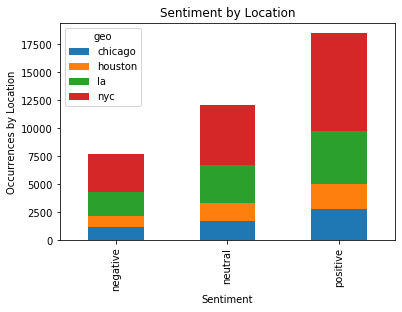

In [11]:
fig = grouped.unstack().plot(kind='bar', stacked=True, align="center")

fig.set_title('Sentiment by Location')

fig.set_xlabel('Sentiment')
fig.set_ylabel('Occurrences by Location')

plt.savefig('Images/sentiment_bars')

Overall, sentiment is mostly positive in all locations, even though they all have a different volume of data. I'll need to factor in that Textblob is not necessarily 100% accurate, and many times interpretation can be subjective, especially when the tweet itself is negative but the overall opinion toward vaccines is conveyed as positive. 

To look deeper into positive vs negative, I'm going to show the most frequent words and visualize with a word cloud. This will require further text cleaning to make sure I'm getting the most relevant results. I'll start by separating positive, negative, and neutral data into separate dataframes.

In [12]:
negatives = df[df['tb_sentiment'] == 'negative'].reset_index()
positives = df[df['tb_sentiment'] == 'positive'].reset_index()
neutral = df[df['tb_sentiment'] == 'neutral'].reset_index()

When I first ran the text analysis I saw that contractions were being split and strings like "n't" were showing up as frequent words. To solve this I am using a py file and function imported from [this repository](https://github.com/dipanjanS/practical-machine-learning-with-python) in order to map contractions to full words. After defining the fuction and applying it across all the text data, I can see the results in the example below.

In [13]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    """
    Using the contractions.py file cloned to this repository, 
    defines a regex pattern and uses it to map contractions to
    full words and replace them in the text.
    """
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


In [14]:
positives['clean_text'] = list(map(expand_contractions, positives['clean_text']))
negatives['clean_text'] = list(map(expand_contractions, negatives['clean_text']))
neutral['clean_text'] = list(map(expand_contractions, neutral['clean_text']))

Then I am using NLTK's stopwords list to remove words that don't add meaning (i.e. 'is', 'who', 'for') and adding punctuation, as well as the term 'vaccine' as this should be in every tweet. I can see that Twint is also pulling in some things as weird characters so I'm adding those to my punctuation list so they'll be removed.

In [15]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``', 'amp', "'", '"', "`", "â€™", "â€",
              'ðÿ', '’', '¯', 'ðÿ™', 'â€˜', 'â€�', 'â€œ', 'ðÿ˜', '�ðÿ', '‘', '�']
stopwords_list += punct_list
stopwords_list.extend(['vaccine', 'vaccines', 'get', 'got', 'getting'])

Then I'm going to incorporate this into a tokenize function that will tokenize the data, lowercase words, and remove stopwords and symbols all at once.

In [16]:
def tokenize(tweet):
    """
    Preps text data for processing by passing
    several data cleaning techniques at once:
    mapping contractions, lowercasing, and 
    removing stopwords/punctuation
    """
    tokens = nltk.word_tokenize(tweet)
    words_lower = [word.lower() for word in tokens]
    words_stopped = [
        word for word in words_lower if word not in stopwords_list]

    return words_stopped

In [17]:
processed_data_positive = list(map(tokenize, positives['clean_text']))
processed_data_negative = list(map(tokenize, negatives['clean_text']))
processed_data_neutral = list(map(tokenize, neutral['clean_text']))
processed_data_positive[0]

['definitely',
 'required',
 'every',
 'public',
 'location',
 'library',
 'dmv',
 'etc',
 'also',
 'private',
 'locations',
 'grocery',
 'stores',
 'etc',
 'countries',
 'suffering',
 'lol',
 'us',
 'japan',
 'still',
 'state',
 'emergency',
 'canada',
 'barely',
 'virus',
 'cant',
 'stopped']

To get a visual of my positive vs negative data, I'm going to create word clouds. To make these, I'm compiling a frequency distribution of most common words in positive and negative labeled data and using the top 500 for the word cloud.

In [18]:
pos_tweet_concat = []
for tweet in processed_data_positive:
    pos_tweet_concat += tweet
    
pos_tweet_freqdist = FreqDist(pos_tweet_concat)

In [19]:
neg_tweet_concat = []
for tweet in processed_data_negative:
    neg_tweet_concat += tweet
    
neg_tweet_freqdist = FreqDist(neg_tweet_concat)

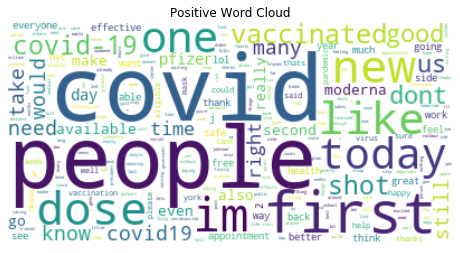

In [20]:
p_wc = WordCloud(background_color="white", max_words=500)
p_wc.generate_from_frequencies(pos_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(p_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Positive Word Cloud')
plt.show()

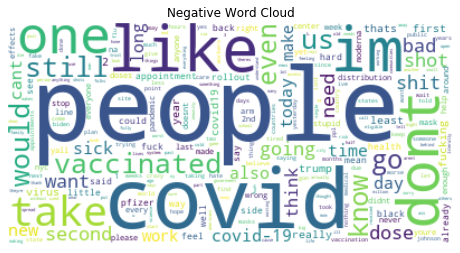

In [21]:
n_wc = WordCloud(background_color="white", max_words=500)
n_wc.generate_from_frequencies(neg_tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(n_wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.title('Negative Word Cloud')
plt.show()

The word clouds give some indication of what positive and negative sentiment revolves around: with the positive word cloud there are a lot of terms around availability (today, available, new, appointment, first/second dose), where in the second there are terms that show concern about being able to get a shot as well as the effects: (work, effects, sick, need, time).

Next, I want to create a dataframe that shows how sentiment trends over time, which I'll use to correlate with the vaccination rate data. I'll do this by taking the average polarity score over time overall, and then for each city.

In [22]:
sent_over_time = df[['date', 'tb_polarity']].sort_values(by ='date')
sent_over_time['date'] =pd.to_datetime(sent_over_time['date'])
sent_over_time = sent_over_time.groupby('date').mean()

In [23]:
sent_over_time

,tb_polarity
date,
2021-01-01,0.076993
2021-01-02,0.042148
2021-01-03,0.033957
2021-01-04,0.082764
2021-01-05,0.078048
...,...
2021-06-09,0.092711
2021-06-10,0.066310
2021-06-11,0.071087


Text(0.5, 1.0, 'Polarity Score Over Time')

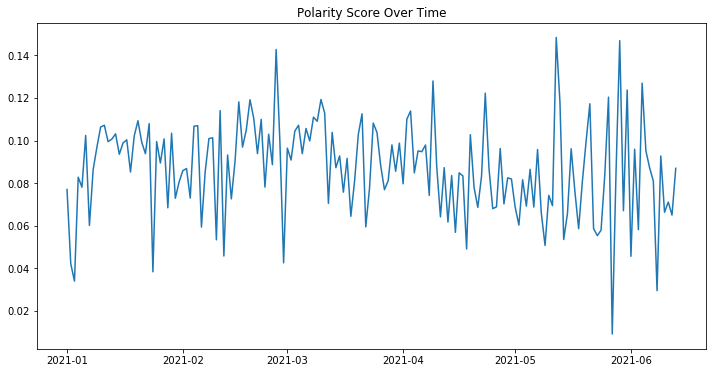

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(sent_over_time)
plt.title("Polarity Score Over Time")

Overall, the trend looks pretty random with a few dramatic spikes, centered around a mean of ~0.08. Let's take a closer look at different locations. 

In [25]:
def sent_by_location(df, location):
    
    """
    creates time series of average polarity score 
    over time specific to each location passed in.
    """
    
    location_df = df[df['geo'] == location]
    location_df = location_df[['date', 'tb_polarity']].sort_values(by ='date').groupby('date').mean()
    location_df.index = pd.to_datetime(location_df.index)
    return location_df

In [26]:
hou_sent = sent_by_location(df, 'houston')
chi_sent = sent_by_location(df, 'chicago')
nyc_sent = sent_by_location(df, 'nyc')
la_sent = sent_by_location(df, 'la')

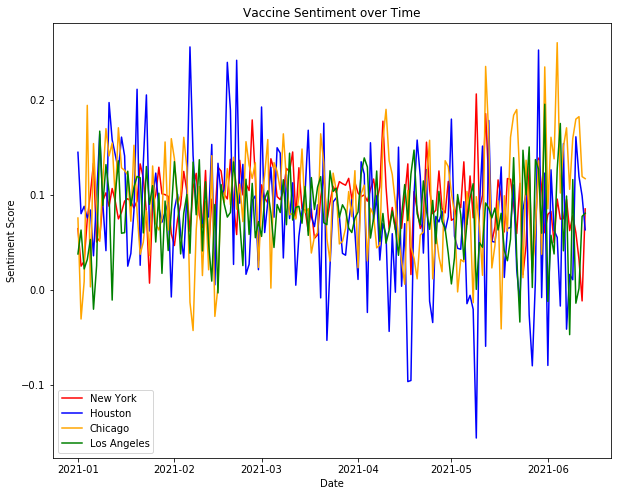

In [27]:
fig = plt.figure(figsize=(10, 8))
plt.plot(nyc_sent, label='New York', color='red')
plt.plot(hou_sent, label='Houston', color='blue')  
plt.plot(chi_sent, label='Chicago', color='orange')  
plt.plot(la_sent, label='Los Angeles', color='green')
plt.xlabel('Date')  
plt.ylabel('Sentiment Score') 
plt.title("Vaccine Sentiment over Time")  
plt.legend() 
# plt.savefig("Images/vaccine_sentiment")

In [28]:
print("NYC average polarity score: ", round(nyc_sent['tb_polarity'].mean(), 3))
print("Houston average polarity score: ", round(hou_sent['tb_polarity'].mean(),3))
print("Chicago average polarity score: ", round(chi_sent['tb_polarity'].mean(), 3))
print("Los Angeles average polarity score: ", round(la_sent['tb_polarity'].mean(), 3))

NYC average polarity score:  0.093
Houston average polarity score:  0.077
Chicago average polarity score:  0.092
Los Angeles average polarity score:  0.079


While all cities see a lot of fluctuation, NYC and Chicago have quite a high average showing that attitudes are very positive. NYC overall looks quite consistent, while in Chicago there are more dramatic highs and lows suggesting that opinion there is more polarized. 

Interestingly, LA and Houston have close averages. Houston we can see is the 'spikiest' of all with more dramatic swings in average whereas LA shows a bit more consistency. I'm going to export each of these so I can import them into my notebook of vaccine data, in order to conduct a correlation analysis.

In [29]:
#exporting these dataframes to use in my other notebook

# hou_sent.to_csv('data/houston_sentiment.csv')
# chi_sent.to_csv('data/chicago_sentiment.csv')
# nyc_sent.to_csv('data/nyc_sentiment.csv')
# la_sent.to_csv('data/la_sentiment.csv')

## Cluster Analysis

I'm using unsupervised learning techniques to do a clustering analysis to explore topics of conversation within my data. I'll look at positive vs negative vs neutral topics to see if there is any clear differentiation.

I'm using a Latent Dirichlet Allocation (LDA) model, a probabilistic model that sees a document as a mix of topics, and a maps each word to a topic. 

This LDA model comes from Gensim and requires an input number of topics, as well a the body of text and a dictionary of word IDs and words.

### Positive Topics

In [30]:
# Create Dictionary
pos_id2word = corpora.Dictionary(processed_data_positive)

# Term Document Frequency
pos_corpus = [pos_id2word.doc2bow(text) for text in processed_data_positive]

# View the result
print(pos_corpus[:1][0][:10])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1)]


In [31]:
# Build LDA model
pos_lda_model = gensim.models.LdaMulticore(corpus=pos_corpus,
                                       id2word=pos_id2word,
                                       num_topics=3)
# Print the keywords in the topics
pprint(pos_lda_model.print_topics())
doc_lda = pos_lda_model[pos_corpus]

[(0,
  '0.013*"covid" + 0.011*"people" + 0.010*"first" + 0.008*"new" + 0.005*"like" '
  '+ 0.005*"dont" + 0.005*"today" + 0.005*"know" + 0.005*"covid-19" + '
  '0.004*"shot"'),
 (1,
  '0.010*"first" + 0.010*"im" + 0.008*"people" + 0.007*"dose" + 0.006*"covid" '
  '+ 0.006*"one" + 0.006*"still" + 0.005*"covid-19" + 0.005*"day" + '
  '0.004*"good"'),
 (2,
  '0.012*"covid" + 0.007*"like" + 0.007*"people" + 0.005*"know" + '
  '0.004*"first" + 0.004*"would" + 0.004*"”" + 0.004*"im" + 0.003*"think" + '
  '0.003*"one"')]


In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()

In [33]:
pos_LDAvis_prepared = pyLDAvis.gensim.prepare(pos_lda_model, pos_corpus, pos_id2word)

In [34]:
with open('Files/pos_LDAvis_prepared.pickle', 'wb') as f:
        pickle.dump(pos_LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data 
with open('Files/pos_LDAvis_prepared.pickle', 'rb') as f:
    pos_LDAvis_prepared = pickle.load(f)

pos_LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.002779 -0.047862  1       1        33.479959
1     -0.044495  0.021616  2       1        33.452766
0      0.041716  0.026246  3       1        33.067275, topic_info=        Term         Freq        Total Category  logprob  loglift
1609  im      1677.000000  1677.000000  Default  30.0000  30.0000
121   new     1239.000000  1239.000000  Default  29.0000  29.0000
108   know    942.000000   942.000000   Default  28.0000  28.0000
203   first   2252.000000  2252.000000  Default  27.0000  27.0000
20    still   887.000000   887.000000   Default  26.0000  26.0000
...     ...          ...          ...       ...      ...      ...
270   really  239.988071   659.925535   Topic3  -5.9468   0.0951 
1609  im      368.131343   1677.702818  Topic3  -5.5190  -0.4101 
371   dose    322.960829   1314.547584  Topic3  -5.6499  -0.2971 
192   good    258.154053   898.260193   Topic3  -5.8739  -0.1403 
65    want    221.708119   588.196116   Topic3  -6.0260   0.1309 

[324 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
26076  3      0.970651  -80c
25966  3      0.969719  000 
353    1      0.478481  1   
353    2      0.161227  1   
353    3      0.358861  1   
...   ..           ... ..   
147    2      0.647842  „   
147    3      0.173130  „   
2510   1      0.550730  ‰   
2510   2      0.191664  ‰   
2510   3      0.257169  ‰   

[592 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

The model has grouped words from positive conversation in to three clusters using term frequency. While these aren't the most clearly defined topics, there are definitely some trends in conversation. Topic 1 seems to revolve around getting a first shot and potentially excitement around which vaccine and whether it's a 1 or 2 dose. Topic 2 is similar but leans a bit more toward potential effects (or lack thereof). Topic 3 seems to focus on the availability of vaccines and planning time to get them, with positive words like 'new' and 'good' as qualifiers. 

Using the relevancy slider in the top right, even more can be explored. We see 'free' and 'public' start to pop. 

### Negative Topics

In [35]:
neg_id2word = corpora.Dictionary(processed_data_negative)

neg_corpus = [neg_id2word.doc2bow(text) for text in processed_data_negative]

In [36]:
# Build LDA model
neg_lda_model = gensim.models.LdaMulticore(corpus=neg_corpus,
                                       id2word=neg_id2word,
                                       num_topics=3)

neg_doc_lda = neg_lda_model[neg_corpus]

In [37]:
neg_LDAvis_prepared = pyLDAvis.gensim.prepare(neg_lda_model, neg_corpus, neg_id2word)

In [38]:
with open('Files/neg_LDAvis_prepared.pickle', 'wb') as f:
        pickle.dump(neg_LDAvis_prepared, f)

with open('Files/neg_LDAvis_prepared.pickle', 'rb') as f:
    neg_LDAvis_prepared = pickle.load(f)

neg_LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.018745  0.034267  1       1        40.819689
2     -0.020856 -0.033071  2       1        32.899939
1      0.039601 -0.001196  3       1        26.280372, topic_info=        Term         Freq        Total Category  logprob  loglift
107   people  1163.000000  1163.000000  Default  30.0000  30.0000
6     like    697.000000   697.000000   Default  29.0000  29.0000
148   covid   1029.000000  1029.000000  Default  28.0000  28.0000
364   crazy   129.000000   129.000000   Default  27.0000  27.0000
1102  shot    300.000000   300.000000   Default  26.0000  26.0000
...    ...           ...          ...       ...      ...      ...
64    thats   60.336771    201.496302   Topic3  -6.1955   0.1305 
517   2       59.010232    192.943954   Topic3  -6.2177   0.1517 
58    least   59.382743    198.780522   Topic3  -6.2114   0.1282 
423   bad     61.811972    299.379685   Topic3  -6.1713  -0.2413 
162   one     64.273830    489.202291   Topic3  -6.1323  -0.6933 

[304 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
13674  1      0.805823  13+    
517    1      0.424994  2      
517    2      0.269508  2      
517    3      0.305788  2      
5315   2      0.841117  2019   
...   ..           ... ..      
1512   1      0.312016  ‰      
1512   2      0.240012  ‰      
1512   3      0.456023  ‰      
6347   1      0.207338  �ðÿ�¼ðÿ
6347   3      0.829351  �ðÿ�¼ðÿ

[539 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

On the negative end, we see the opposite side of the situation. Topic 1  doesn't have very clear themes, but the word 'sick' calls to mind the side effects that many people experienced. Topic 2 contains time-based terms - 'year', 'today', 'still' - and also 'appointment', suggesting dissatisfaction around waiting or difficulty in getting an appointment. Topic 3 builds off the two previous - we see terms like 'effects', 'sick', and 'long'. 

When clearing the topic, we see words like 'distribution' and 'waiting'. Overall the challenges seem to be difficulty in getting or making time for a vaccine appointment, and addressing side effects.

### Looking at Location

As this code takes a while to run, I'm wrapping the location-based clustering into a function where location can be selected. 

In [39]:
def topic_by_location(df, location):
    
    ''' 
    inputs: dataframe with cleaned tweets, location
    selects location, cleans and tokenizes words with previously
    defined functions tokenize() and expand contractions()
    runs LDA model and visual output
    '''
    
    topics = df.loc[df.geo == location]['clean_text']

    topics = list(map(expand_contractions, topics))
    topics = list(map(tokenize, topics))

    
    loc_id2word = corpora.Dictionary(topics)

    loc_corpus = [loc_id2word.doc2bow(text) for text in topics]
   
    loc_lda_model = gensim.models.LdaMulticore(corpus=loc_corpus,
                                       id2word=loc_id2word,
                                       num_topics=2)


    loc_doc_lda = loc_lda_model[loc_corpus]
    
    loc_LDAvis_prepared = pyLDAvis.gensim.prepare(loc_lda_model, loc_corpus, loc_id2word)
    
    with open('Files/loc_LDAvis_prepared.pickle', 'wb') as f:
        pickle.dump(loc_LDAvis_prepared, f)


    with open('Files/loc_LDAvis_prepared.pickle', 'rb') as f:
        loc_LDAvis_prepared = pickle.load(f)


    return loc_LDAvis_prepared

In [40]:
#can take a while to run
topic_by_location(df, 'la')

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.013279  0.0  1       1        55.901086
1     -0.013279  0.0  2       1        44.098914, topic_info=         Term        Freq       Total Category  logprob  loglift
20   covid-19  438.000000  438.000000  Default  30.0000  30.0000
23   even      299.000000  299.000000  Default  29.0000  29.0000
403  risk      138.000000  138.000000  Default  28.0000  28.0000
0    making    97.000000   97.000000   Default  27.0000  27.0000
696  great     137.000000  137.000000  Default  26.0000  26.0000
..     ...            ...         ...      ...      ...      ...
32   still     148.801554  427.454040  Topic2  -5.9602  -0.2365 
45   would     143.390176  391.911697  Topic2  -5.9972  -0.1867 
129  know      147.566945  433.873877  Topic2  -5.9685  -0.2597 
165  day       124.906634  311.112881  Topic2  -6.1352  -0.0939 
648  second    132.670979  421.400725  Topic2  -6.0749  -0.3370 

[217 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
73     1      0.683510  2nd    
73     2      0.316074  2nd    
74     1      0.408569  3      
74     2      0.585872  3      
16899  1      0.251851  400,000
...   ..           ... ..      
1464   2      0.197880  �â‚ï¸� 
5593   1      0.943167  �ðÿ�½ðÿ
5593   2      0.188633  �ðÿ�½ðÿ
600    1      0.147194  �ðÿ�¾ðÿ
600    2      0.883166  �ðÿ�¾ðÿ

[329 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

To reduce runtimes, I've pulled out some key words that were unique to each location. While topics were mostly fairly similar, each place had a specific experience with Covid-19 and it's important to take into consideration regional differences. Some unique themes that can be pulled out are:

New York: doses recieved, cuomo, masks, die  
Chicago: effects, efficacy  
Houston: free, mask  
LA: safe, new

## Learnings and Recommendations

In the first part of this notebook, I was able to label Twitter data with sentiment using Textblob, which showed trends over time in sentiment towards vaccines. While Textblob was a good solution to getting labels quickly, a brief look at it can show that it's not 100% accurate. For future work, I would explore different labeling options. 

Separately, the data that was labeled in this project could help with a classification analysis when gathering more data. 

The unsupervised learning piece of this notebook provided several themes around peoples' experience and opinions with the vaccine, both negative and positive. This can help with a starting point on how to develop messaging to encourage more people to get vaccinated. From the data we can see that there are common themes, but unique themes emerge for each location, so it is recommended to use that to tailor messaging. 

For future work, I would recommend trying different text processing methods, such as lemmatization and using bigrams, to see if it helps bring more insight into the data, or even to add more commonly used words to the stopwords list. There are also other text clustering methods that can be explored, and it would be especially helpful to find a method with a shorter runtime. 

# Thank you!